## Notebook 2: Bayesian optimization of building design parameters

**1. Prepare Problem**

In [1]:
# a) Load libraries
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np
from numpy import mean
from builtins import int

import matplotlib.pyplot as plt
import seaborn as sn

from SALib.analyze import sobol
from SALib.sample.sobol import sample as sobol_sample
from SALib.analyze import sobol as sobol_analyze

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.sampler import Lhs
from sklearn.datasets import make_blobs
from skopt.space import Integer
from skopt.utils import use_named_args

from bayes_opt import BayesianOptimization

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

import pickle

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# b) Load dataset
# Load and view each file in the dataset
data = pd.read_csv('EPB_data.csv', header=0)
print(data.shape)
print(data.head(10))
print(data.dtypes)

(768, 10)
   Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   
5                  0.90         563.5      318.5     122.50             7.0   
6                  0.90         563.5      318.5     122.50             7.0   
7                  0.90         563.5      318.5     122.50             7.0   
8                  0.86         588.0      294.0     147.00             7.0   
9                  0.86         588.0      294.0     147.00             7.0   

   Orientation  Glazing Area  Glazing Area Distribution  Heating Load  \
0            2           0.0                   

One of the approach in optimizing building energy efficiency is to minimize total energy consumption, which is the sum of heating and cooling.

In [3]:
# Calculate total energy consumption by summing up heating and cooling loads
data['Energy_Consumption'] = data[['Heating Load', 'Cooling Load']].sum(axis=1)
print(data.shape)

# Define features and label
X = data.drop(columns=['Heating Load', 'Cooling Load', 'Energy_Consumption'], axis = 1)
# Rename columns to remove whitespace
X = X.rename(columns=lambda X: X.strip().replace(' ', '_'))
y = data['Energy_Consumption']
print(X.shape, y.shape)
print(X.head(5))

(768, 11)
(768, 8) (768,)
   Relative_Compactness  Surface_Area  Wall_Area  Roof_Area  Overall_Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   

   Orientation  Glazing_Area  Glazing_Area_Distribution  
0            2           0.0                          0  
1            3           0.0                          0  
2            4           0.0                          0  
3            5           0.0                          0  
4            2           0.0                          0  


**2. Dataset summary**

In [4]:
# a) Descriptive statistics
set_option("display.precision", 3)
print(data.describe())

       Relative Compactness  Surface Area  Wall Area  Roof Area  \
count               768.000       768.000    768.000    768.000   
mean                  0.764       671.708    318.500    176.604   
std                   0.106        88.086     43.626     45.166   
min                   0.620       514.500    245.000    110.250   
25%                   0.682       606.375    294.000    140.875   
50%                   0.750       673.750    318.500    183.750   
75%                   0.830       741.125    343.000    220.500   
max                   0.980       808.500    416.500    220.500   

       Overall Height  Orientation  Glazing Area  Glazing Area Distribution  \
count         768.000      768.000       768.000                    768.000   
mean            5.250        3.500         0.234                      2.812   
std             1.751        1.119         0.133                      1.551   
min             3.500        2.000         0.000                      0.000   
2

In [5]:
# checking categorical features
cat_features = data.select_dtypes(include='O').keys()
# display variabels
cat_features

Index([], dtype='object')

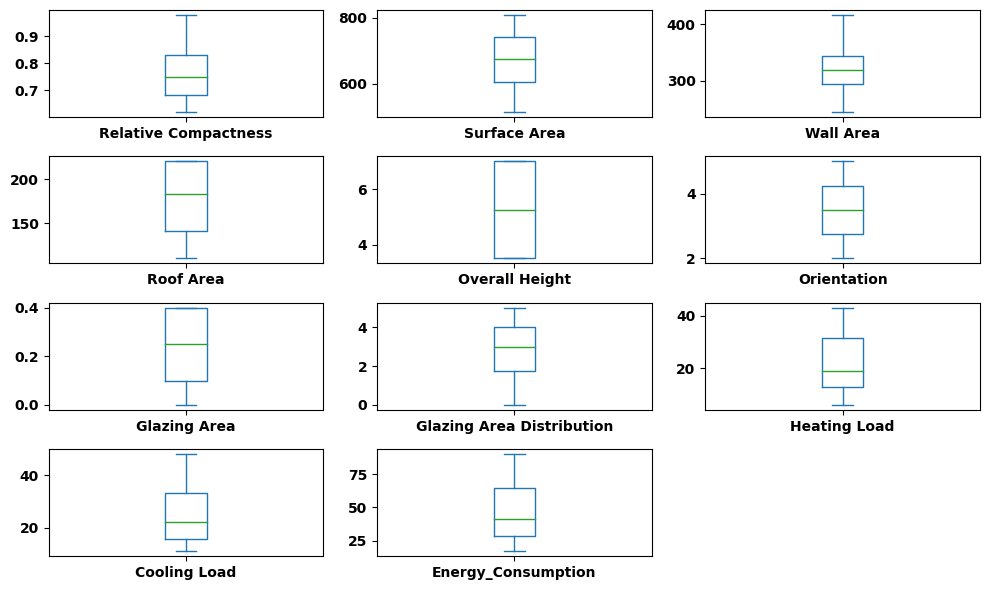

In [6]:
# b) Data visualizations
# Box and Whisker Plots of a few features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False)
plt.show()

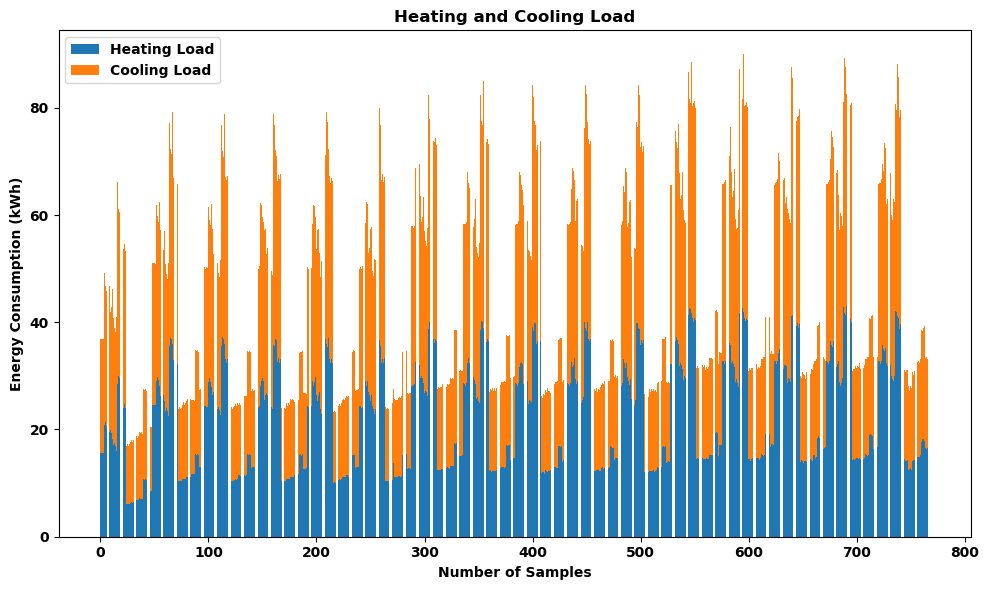

In [7]:
# create the stack bar chart of Heating and Cooling Load
fig, ax = plt.subplots()
ax.bar(np.arange(len(data['Heating Load'])), data['Heating Load'], label='Heating Load')
ax.bar(np.arange(len(data['Cooling Load'])), data['Cooling Load'], bottom=data['Heating Load'], label='Cooling Load')

# add labels, title and legend
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('Heating and Cooling Load')
ax.legend()

# show the plot
plt.show()

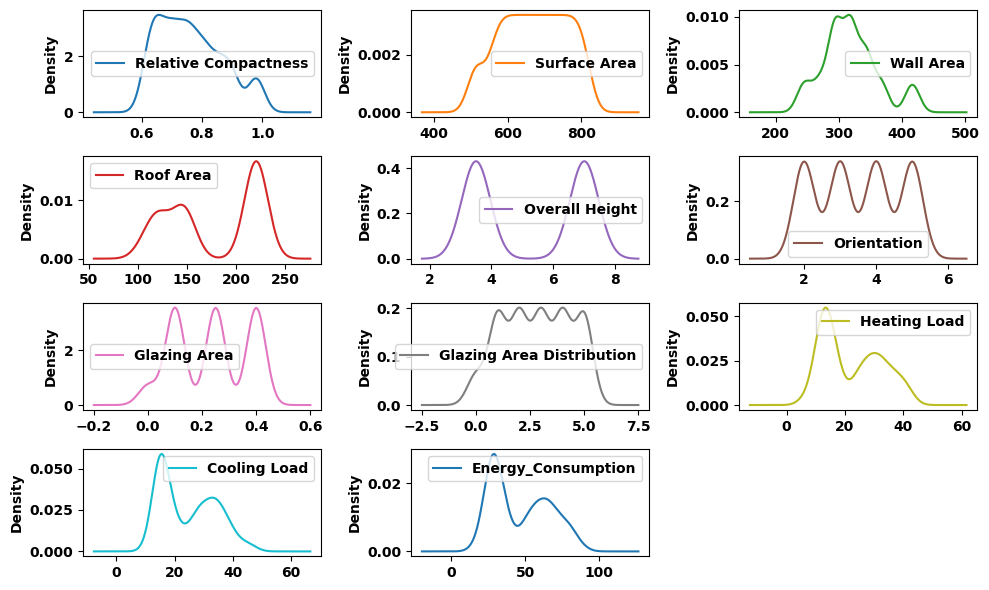

In [8]:
# Create density plots to check the Gaussian distribution of features
raw_plot.plot(kind='density', subplots=True, layout=(4,3), sharex=False)
plt.show()

It appears that only surface area follows Gaussian distrbution. The nonlinearity of other featues suggest that this is a complicated dataset.

                           Relative Compactness  Surface Area  Wall Area  \
Relative Compactness                  1.000e+00    -9.919e-01 -2.038e-01   
Surface Area                         -9.919e-01     1.000e+00  1.955e-01   
Wall Area                            -2.038e-01     1.955e-01  1.000e+00   
Roof Area                            -8.688e-01     8.807e-01 -2.923e-01   
Overall Height                        8.277e-01    -8.581e-01  2.810e-01   
Orientation                           4.679e-17    -3.459e-17 -2.429e-17   
Glazing Area                         -2.961e-15     3.637e-15 -8.567e-17   
Glazing Area Distribution            -7.107e-16     2.438e-15  2.067e-16   
Heating Load                          6.223e-01    -6.581e-01  4.557e-01   
Cooling Load                          6.343e-01    -6.730e-01  4.271e-01   
Energy_Consumption                    6.319e-01    -6.694e-01  4.445e-01   

                           Roof Area  Overall Height  Orientation  \
Relative Compactne

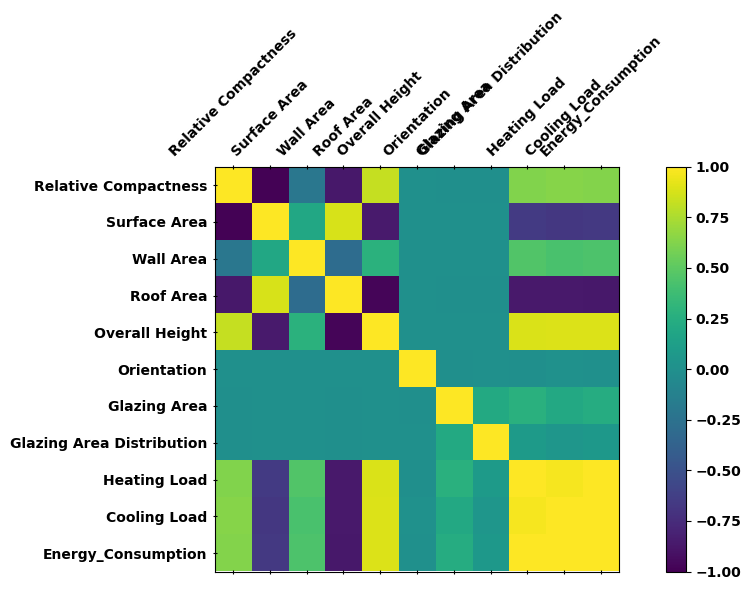

In [9]:
# correlation matrix between all pairs of attributes
print(data.corr(method='pearson'))
names = list(data)
fig = plt.figure()
sub_fig = fig.add_subplot(111)
cm = sub_fig.matshow(data.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cm)
sub_fig.tick_params(direction='inout')
sub_fig.set_xticks(np.arange(0,11))
sub_fig.set_yticks(np.arange(0,11))
sub_fig.set_xticklabels(names, rotation=45)
sub_fig.set_yticklabels(names)
plt.show()

The correlation matrix indicates heating and coolind loads and energy consumption are strongly correlated to Overall Height and Relative Compactness. 

The Sobol indices are a measure of the importance of each input variable in a simulation model, with respect to its contribution to the output variability. They can be used to determine the most important input variables and to prioritize the areas for improvement in a building design.

In [10]:
# Define the problem for Sobol analysis
problem = {
    'num_vars': 8,
    'names': ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution'],
    'bounds': [(X.iloc[:, i].min(), X.iloc[:, i].max()) for i in range(8)]
}

In [11]:
# Load the fitted Random Forest model from disk
with open('finalized_model.sav', 'rb') as file:
    model_RF = pickle.load(file)

In [12]:
N = 1024 # number of samples
# Generate samples
X_sobol = sobol_sample(problem, N, calc_second_order=False)
# Calculate the Sobol Indices for each target variable
y_sobol = model_RF.predict(X_sobol)
Si = sobol.analyze(problem, y_sobol, calc_second_order=False)

The Sobol indices sensitivity analysis suggest that there is a strong correlation between Energy Consumption and three factors: Glazing Area, Glazing Area Distribution, and Relative Compactness.

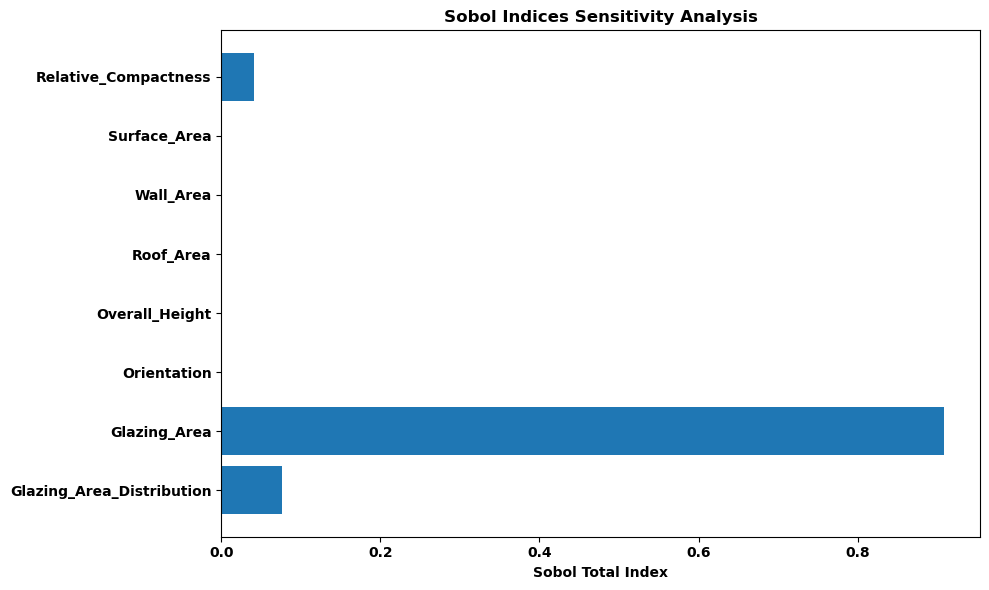

Total Sobol Indices for ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution']: 1.0263058383751318


In [13]:
# Plot the first-order Sobol Indices
fig, ax = plt.subplots()
indices = Si['ST']
names = problem['names']
y_pos = np.arange(len(names))
ax.barh(y_pos, indices)
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()
ax.set_xlabel('Sobol Total Index')
ax.set_title('Sobol Indices Sensitivity Analysis')
plt.show()

# Print the total Sobol Indices
print(f"Total Sobol Indices for {list(X.columns)}: {Si['ST'].sum()}")

**3. Prepare Data**

In [14]:
# a) Data Cleaning
# summarize the number of unique values in each column
print(data.nunique())

Relative Compactness          12
Surface Area                  12
Wall Area                      7
Roof Area                      4
Overall Height                 2
Orientation                    4
Glazing Area                   4
Glazing Area Distribution      6
Heating Load                 586
Cooling Load                 636
Energy_Consumption           700
dtype: int64


In [15]:
# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
Energy_Consumption           0
dtype: int64


It is necessary to eliminate outliers in numerical data columns to improve the accuracy of training and validation processes. This can be done by determining the correlation between these columns and the target variable, identifying columns with low correlation, and then filtering out values that fall outside of the lower and upper bounds.

In [16]:
# calculate the correlation between numerical columns and target variable
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Energy_Consumption']).sort_values(ascending=False)

# filter columns with low correlation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

**4. Evaluate Algorithms**

Once the Random Forest model was trained, we can use them as the surrogate models in the Bayesian optimization process. The optimization algorithm will update the models and use them to predict the energy consumption and carbon footprint for different sets of design parameters, and select the next set of parameters to evaluate based on the estimated performance of the model.

To perform optimization under uncertainty using Bayesian optimization framework, we need to define a prior distribution over the input space, collect data to update the prior into a posterior distribution, and use this posterior to select the next input value to evaluate the surrogate model. The process continues until the convergence criterion is met. 

In [17]:
# Step 1: Import necessary libraries and define the surrogate model
# Define the surrogate model
def surrogate(x):
    return model_RF.predict(x.reshape(1, -1))[0]

In [18]:
# Step 2: Define the objective function, constraints, and uncertainty distributions
# Define the objective function and constraints
def objective(x, model_RF):
    return surrogate(np.array(x)) 

In [19]:
distributions = [Real(X.iloc[:,0].min(), X.iloc[:,0].max(), name='Relative_Compactness'),
                Real(X.iloc[:,1].min(), X.iloc[:,1].max(), name='Surface_Area'),
                Real(X.iloc[:,2].min(), X.iloc[:,2].max(), name='Wall_Area'),
                Real(X.iloc[:,3].min(), X.iloc[:,3].max(), name='Roof_Area'),
                Real(X.iloc[:,4].min(), X.iloc[:,4].max(), name='Overall_Height'),
                Integer(X.iloc[:,5].min(), X.iloc[:,5].max(), name='Orientation'),
                Real(X.iloc[:,6].min(), X.iloc[:,6].max(), name='Glazing_Area'),
                Integer(X.iloc[:,7].min(), X.iloc[:,7].max(), name='Glazing_Area_Distribution')]

In [20]:
# Step 3: Define the prior distribution

# Define the prior distribution over the search space
def prior(X):
    prior_dict = {}
    for key, value in distributions.items():
        if key in X:
            prior_dict[key] = value
    return prior_dict

The likelihood function is not needed ecause we are assuming that the surrogate model has already been trained and optimized, and we are simply using it to perform Bayesian optimization.

In Bayesian optimization, we use the posterior distribution to select the next set of input variables to evaluate. Specifically, we choose the input variables that maximize an acquisition function, which is a function that balances exploration (sampling input variables where the posterior distribution is uncertain) and exploitation (sampling input variables that are likely to yield high objective values). The acquisition function is defined in terms of the posterior distribution and its derivatives, so it plays an important role in the optimization process.

In [21]:
# Step 4: Define the acquisition function with EI

def acquisition(x, X, y, model_RF):
    # Predict the mean and variance of the objective function at x
    mean, std = model_RF.predict(x.reshape(1, -1), return_std=True)
    
    # Compute the best objective seen so far
    best = np.max(y)
    
    # Compute the acquisition function value at x
    z = (mean - best) / std
    phi = norm.pdf(z)
    Phi = norm.cdf(z)
    EI = std * (z * Phi + phi)
    
    return EI

In [22]:
# Step 5: Define the main Bayesian optimization function

def bayesian_optimization(X, y, model_RF, n_calls, random_start, verbose=True):
    # Define the search space
    space = distributions
    
    # Define the sampling method for the initial random searches
    lhs = Lhs(lhs_type="classic", criterion='maximin')

    # Perform the random searches
    X_random = lhs.generate(space, random_start)
    Y_random = [objective(x, model_RF) for x in X_random]
    
    # Define the optimization function
    @use_named_args(space)
    def func(**params):
        x = [params[key] for key in X.columns]
        return objective(x, model_RF)

    # Define the optimizer
    optimizer = gp_minimize(
        func,
        dimensions=space,
        acq_func='EI',
        n_calls=n_calls - random_start,
        n_random_starts=0,
        x0=X_random,
        y0=Y_random,
        verbose=verbose,
    )
    # Define empty lists to store the function values and iteration numbers
    x_values = []
    func_values = []

    for i in range(n_calls):
        print(f"Iteration No: {i+1} started. Evaluating function.")
        x_next = X_random
        x_values.append(x_next)
        print(f"Iteration No: {i+1} ended. Evaluation done.")
        print(f"X at iteration {i+1}: {x_next}")
        
        # Append the function value and iteration number to their respective lists
        func_values.append(optimizer.func_vals[i])
        print(optimizer.func_vals[i])
        
    return x_values, func_values

In [23]:
# Step 6: Run the Bayesian optimization

# Run the Bayesian optimization
x_values, func_values = bayesian_optimization(X,
                               y,
                               model_RF,
                               n_calls=50,
                               random_start=1,
                               verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2904
Function value obtained: 57.6850
Current minimum: 57.6850
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 0.3670
Function value obtained: 61.8960
Current minimum: 57.6850
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 0.7158
Function value obtained: 57.6850
Current minimum: 57.6850
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 0.6932
Function value obtained: 56.0020
Current minimum: 56.0020
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 0.7639
Function value obtained: 63.0350
Cu

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 1.2417
Function value obtained: 52.0270
Current minimum: 52.0270
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 1.4382
Function value obtained: 52.0270
Current minimum: 52.0270
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.4389
Function value obtained: 52.0270
Current minimum: 52.0270
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.4801
Function value obtained: 52.0270
Current minimum: 52.0270
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.5286
Function value obtained: 52.0270
Current minimum: 52.0270
Iteration No: 46 st

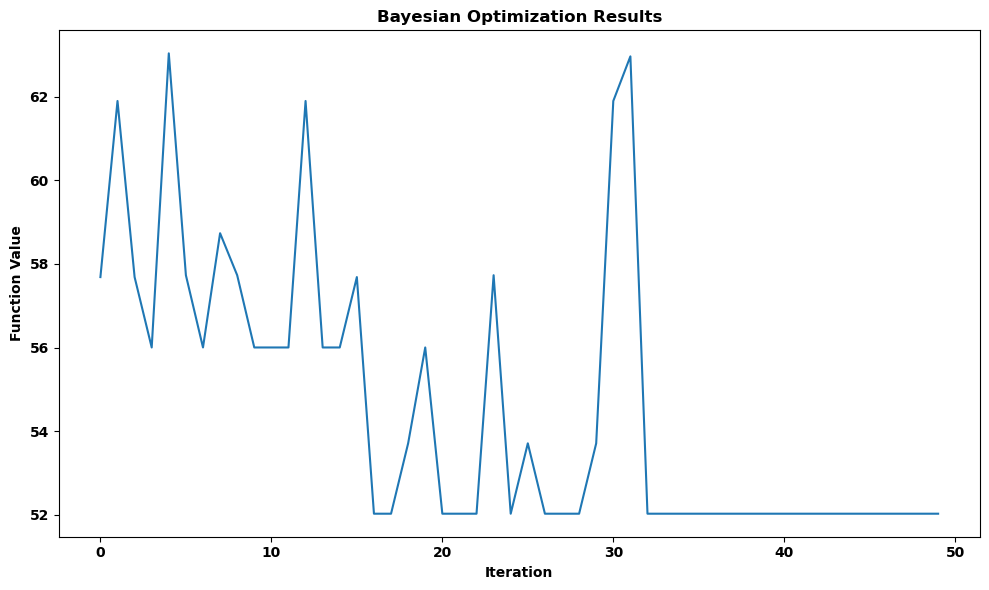

In [24]:
# Plot the function value versus the iteration number
plt.plot(range(len(func_values)), func_values)
plt.xlabel("Iteration")
plt.ylabel("Function Value")
plt.title("Bayesian Optimization Results")
plt.show()

In [25]:
# Print the last value of X or optimum set of operational parameters that yield minimum energy consumption
# Get the index of the minimum value in func_values
min_index = func_values.index(min(func_values))
    
# Return the corresponding value in x_values
x_min = x_values[min_index]

print(f"Minimum Energy Consumption (kWh): {min(func_values)}")
print()
print("Optimum X value:")
for col_name, col_value in zip(X.columns, x_min[0]):
    print(f"{col_name}: {col_value}")

Minimum Energy Consumption (kWh): 52.027

Optimum X value:
Relative_Compactness: 0.8361513236072707
Surface_Area: 527.6030983395492
Wall_Area: 374.2615908212671
Roof_Area: 209.58428804503302
Overall_Height: 3.8438168785221327
Orientation: 3
Glazing_Area: 0.015270722153852124
Glazing_Area_Distribution: 2


**5. Conclusions**

- The Sobol indices sensitivity analysis suggest that there is a strong correlation between Energy Consumption and three factors: Glazing Area, Glazing Area Distribution, and Relative Compactness.

- After approximately 40 iterations, the optimization process converges to a minimum Energy Consumption of 52.027 kWh.

- While the Bayesian framework is a viable solution for this optimization problem, there are other popular optimization packages, such as Pyomo and PyGMO, that could also provide robust solutions. It may be worthwhile to explore these options.